In [43]:
import skmob
from skmob.preprocessing import detection, clustering, compression
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from skmob.tessellation import tilers
from shapely.geometry import Point, Polygon
import h3
#import shapely
import shapely.geometry
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import contextily as ctx
from shapely import wkt
from shapely.geometry import LineString

import warnings
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [44]:
dataFrame = pd.read_csv('../Trips.csv')
#dataFrame.drop('Unnamed: 0.1', axis=1, inplace=True)
dataFrame.drop('Unnamed: 0', axis=1, inplace=True)

In [45]:
block = gpd.read_file("../Census-block.geojson")
block.head()

,intptlon,awater,mtfcc,aland,namelsad,tractce,statefp,data_loaded_at,intptlat,funcstat,countyfp,data_as_of,geoid,blkgrpce,geometry
0,-122.4131872,0.0,G5030,15762.0,Block Group 2,11901,6,2022-07-25 14:01:00,37.791044499999998,S,75,2022-07-21 22:57:39.866,60750119012,2,"MULTIPOLYGON (((-122.41411 37.79142, -122.4124..."
1,-122.41896029999999,0.0,G5030,23109.0,Block Group 1,12202,6,2022-07-25 14:01:00,37.786235900000001,S,75,2022-07-21 22:57:39.866,60750122021,1,"MULTIPOLYGON (((-122.41993 37.78683, -122.4182..."
2,-122.4340234,0.0,G5030,59496.0,Block Group 3,13500,6,2022-07-25 14:01:00,37.789808399999998,S,75,2022-07-21 22:57:39.866,60750135003,3,"MULTIPOLYGON (((-122.43585 37.79050, -122.4342..."
3,-122.4353981,0.0,G5030,92245.0,Block Group 2,13002,6,2022-07-25 14:01:00,37.796622900000003,S,75,2022-07-21 22:57:39.866,60750130022,2,"MULTIPOLYGON (((-122.43733 37.79781, -122.4356..."
4,-122.42785739999999,0.0,G5030,76918.0,Block Group 2,16802,6,2022-07-25 14:01:00,37.773488100000002,S,75,2022-07-21 22:57:39.866,60750168022,2,"MULTIPOLYGON (((-122.43082 37.77397, -122.4291..."


In [46]:
odFrame = pd.read_csv('../Eightam.csv')
odFrame.drop('Unnamed: 0', axis=1, inplace=True)
odFrame.head()

,latitude,Longitude,occupancy,time,user,trip,geometry,Time
0,37.75153,-122.39447,0,5/17/2008 14:12:10,new_abboip,1,POINT (-122.39447 37.75153),14:12:10
1,37.75149,-122.39447,0,5/17/2008 14:13:34,new_abboip,1,POINT (-122.39447 37.75149),14:13:34
2,37.75149,-122.39447,0,5/17/2008 14:14:34,new_abboip,1,POINT (-122.39447 37.75149),14:14:34
3,37.75149,-122.39446,0,5/17/2008 14:15:35,new_abboip,1,POINT (-122.39446 37.75149),14:15:35
4,37.75144,-122.39449,0,5/17/2008 14:41:43,new_abboip,1,POINT (-122.39449 37.75144),14:41:43


In [ ]:
blockframe = gpd.GeoDataFrame(data = odFrame, crs='epsg:4326', 
                            geometry= gpd.points_from_xy(odFrame.Longitude, odFrame.latitude))
odframe = gpd.sjoin(blockframe, block , how='left', predicate='within')

In [ ]:
tripIDList = list(odframe['trip'].unique())
odframe.columns

In [ ]:
originDestinationBlock = pd.DataFrame(columns = ['latitude', 'Longitude', 'occupancy', 'time', 'user', 'trip',
       'geometry', 'Time', 'index_right', 'intptlon', 'awater', 'mtfcc',
       'aland', 'namelsad', 'tractce', 'statefp', 'data_loaded_at', 'intptlat',
       'funcstat', 'countyfp', 'data_as_of', 'geoid', 'blkgrpce', 'origin', 'destination'])

In [ ]:
for index, value in enumerate(tripIDList):
    print(index)
    dFrame = odframe[odframe['trip'] == value]
    origin = dFrame.geoid.iloc[0]
    destination = dFrame.geoid.iloc[-1]
    print(origin, destination)
    originDestinationBlock.loc[len(originDestinationBlock)] = [dFrame.latitude.iloc[0], dFrame.Longitude.iloc[0], dFrame.occupancy.iloc[0], dFrame.time.iloc[0], dFrame.user.iloc[0], dFrame.trip.iloc[0],
            dFrame.geometry.iloc[0], dFrame.Time.iloc[0], dFrame.index_right.iloc[0], dFrame.intptlon.iloc[0], dFrame.awater.iloc[0], dFrame.mtfcc.iloc[0], dFrame.aland.iloc[0],
            dFrame.namelsad.iloc[0], dFrame.tractce.iloc[0], dFrame.statefp.iloc[0], dFrame.data_loaded_at.iloc[0],dFrame.intptlat.iloc[0],dFrame.funcstat.iloc[0], dFrame.countyfp.iloc[0], 
            dFrame.data_as_of.iloc[0], dFrame.blkgrpce.iloc[0], dFrame.geoid.iloc[0], origin, destination]    


In [ ]:
originDestinationBlock.to_csv('originDestinationBlock.csv')

In [47]:
originDestination = pd.read_csv('originDestinationBlock.csv')

In [48]:
ODCounts = originDestination.groupby(['origin', 'destination']).size().reset_index(name='count')
ODCounts.sort_values(by=['count'], ascending=False)

,origin,destination,count
11884,60750128021.00000,60750128021.00000,256
41237,60750615012.00000,60750615012.00000,230
8655,60750123013.00000,60750123013.00000,214
1436,60750106002.00000,60750106002.00000,204
9317,60750123023.00000,60750123023.00000,195
...,...,...,...
17564,60750161022.00000,60750129023.00000,1
17563,60750161022.00000,60750126012.00000,1
17562,60750161022.00000,60750123023.00000,1
17561,60750161022.00000,60750123012.00000,1


In [49]:
sameOD = ODCounts[ODCounts['origin'] == ODCounts['destination']]
diffOD = ODCounts[ODCounts['origin'] != ODCounts['destination']]

In [50]:
diffOD['origin'] =[np.format_float_positional(x) for x in diffOD['origin']]
diffOD['destination'] =[np.format_float_positional(x) for x in diffOD['destination']]

/tmp/ipykernel_64/394843958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diffOD['origin'] =[np.format_float_positional(x) for x in diffOD['origin']]
/tmp/ipykernel_64/394843958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diffOD['destination'] =[np.format_float_positional(x) for x in diffOD['destination']]


In [51]:
diffOD.sort_values(by=['count'], inplace = True, ascending=False)
diffOD.to_csv('diffOD.csv')

/tmp/ipykernel_64/3880168732.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diffOD.sort_values(by=['count'], inplace = True, ascending=False)


In [52]:
analysis_1DF = originDestination[(originDestination['origin'] == 60750106002) & (originDestination['destination'] == 60750123013)]

analysis_2DF = originDestination[(originDestination['origin'] == 60750610003) & (originDestination['destination'] == 60750615012)]

In [53]:
analysis_1trips = list(analysis_1DF['trip'])
analysis_2trips = list(analysis_2DF['trip'])

In [54]:
analysis = gpd.read_file('../analysis_.geojson')
analysis2 = gpd.read_file('../analysis_2.geojson')

In [55]:
points1 = dataFrame[dataFrame['trip'].isin(analysis_1trips)]
points2 = dataFrame[dataFrame['trip'].isin(analysis_2trips)]

points1 = gpd.GeoDataFrame(data=points1, crs='epsg:4326', 
                             geometry=gpd.points_from_xy(points1.Longitude, points1.latitude))
points2 = gpd.GeoDataFrame(data=points2, crs='epsg:4326', 
                              geometry=gpd.points_from_xy(points2.Longitude, points2.latitude))

In [56]:
intersect = gpd.sjoin(points1, analysis, predicate ='intersects')
intersect = intersect[['OBJECTID', 'GRID_ID', 'geoid', 'Longitude', 'latitude', 'geometry', 'trip','Time']]

intersect2 = gpd.sjoin(points2, analysis2, predicate ='within')
intersect2 = intersect2[['OBJECTID', 'GRID_ID', 'geoid', 'Longitude','latitude', 'geometry', 'trip',  'Time']]

In [57]:
intersect.sort_values(['trip', 'Time'],ascending = True,  inplace=True)
intersect2.sort_values(['trip', 'Time'],ascending = True,  inplace=True)

In [58]:
intersect.drop_duplicates(subset=['trip', 'geometry'], keep='last')
intersect2.drop_duplicates(subset=['trip', 'geometry'], keep='last')

,OBJECTID,GRID_ID,geoid,Longitude,latitude,geometry,trip,Time
75941,96634,NaN,60750610003,-122.39762,37.71473,POINT (-122.39762 37.71473),6773,07:47:20
75942,113473,AKW-1042,NaN,-122.40253,37.72757,POINT (-122.40253 37.72757),6773,07:48:08
75943,39363,AJX-977,NaN,-122.40790,37.74021,POINT (-122.40790 37.74021),6773,07:49:00
75944,59203,AKV-911,NaN,-122.40285,37.75315,POINT (-122.40285 37.75315),6773,07:49:53
75945,60057,AKL-842,NaN,-122.40488,37.76654,POINT (-122.40488 37.76654),6773,07:50:50
...,...,...,...,...,...,...,...,...
9672976,76210,AKI-797,NaN,-122.40552,37.77523,POINT (-122.40552 37.77523),907466,07:30:50
9672977,4292,AMB-767,NaN,-122.39599,37.78125,POINT (-122.39599 37.78125),907466,07:31:50
9672978,101658,NaN,60750615012,-122.40192,37.78610,POINT (-122.40192 37.78610),907466,07:32:50
9672979,101658,NaN,60750615012,-122.40283,37.78684,POINT (-122.40283 37.78684),907466,07:33:52


In [59]:
line_intersect1 = intersect.groupby(['trip'])['geometry'].apply(lambda x: LineString(x.tolist()))
line_intersect1 = gpd.GeoDataFrame(line_intersect1, crs='epsg:4326', geometry='geometry')
line_intersect1 = line_intersect1.reset_index()
line_intersect1.head()

line_intersect2 = intersect2.groupby(['trip'])['geometry'].apply(lambda x: LineString(x.tolist()))
line_intersect2 = gpd.GeoDataFrame(line_intersect2, crs='epsg:4326', geometry='geometry')
line_intersect2 = line_intersect2.reset_index()
line_intersect2.head()

,trip,geometry
0,6773,"LINESTRING (-122.39762 37.71473, -122.40253 37..."
1,151125,"LINESTRING (-122.39506 37.70925, -122.40053 37..."
2,198441,"LINESTRING (-122.39661 37.71357, -122.40207 37..."
3,282354,"LINESTRING (-122.39817 37.71548, -122.40268 37..."
4,326349,"LINESTRING (-122.39555 37.71162, -122.39555 37..."


In [ ]:
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

lineNos = list(points1['trip'].unique())
tripone_Similarity = pd.DataFrame(columns = ['A', 'B', 'Distance'])

for index, value in enumerate(lineNos):
    dframe = points1[points1['trip'] == value].reset_index()
    dFrame = points1.copy()
    dFrame.drop(dFrame[dFrame.trip == value].index, inplace=True)
    lines = lineNos.copy()
    lines.remove(value)
    for ix, val in enumerate(lines):
        distList = []
        dist = 0
        newFrame = dFrame[dFrame['trip'] == val].reset_index()
        for idx, row in dframe.iterrows():
            distanceList = []
            for ind, Val in newFrame.iterrows():
                points_df = gpd.GeoDataFrame({'geometry': [dframe.geometry.iloc[idx], 
                                                           newFrame.geometry.iloc[ind]]},
                                             crs='EPSG:4326').to_crs('EPSG:3857')
                points_df2 = points_df.shift(1)
                #points_df2.geometry.crs = points_df.crs
                distance = points_df.distance(points_df2)
                distance = distance.loc[1]
                distanceList.append(distance)
                dist += distance
            distList.append(min(distanceList))
        tripone_Similarity.loc[len(tripone_Similarity)] = [value, val, max(distList)]
        del newFrame

tripone_Similarity["A"] = tripone_Similarity["A"].astype(int)
tripone_Similarity["B"] = tripone_Similarity["B"].astype(int)

for index, val in tripone_Similarity.iterrows():
    distList = []
    valA = (tripone_Similarity.A.iloc[index])
    valB = (tripone_Similarity.B.iloc[index])
    distA = (tripone_Similarity.Distance.iloc[index])
    distList.append(distA)
    tripframe = tripone_Similarity[(tripone_Similarity['A'] == valB) & (tripone_Similarity['B'] == valA)].copy()
    distB = tripframe.Distance.iloc[0]
    distList.append(distB)
    distance = max(distList)
    tripone_Similarity.Distance.iloc[index] = distance
    tripone_Similarity.loc[((tripone_Similarity['A'] == valB) & (tripone_Similarity['B'] == valA)), 'Distance'] = distance

In [ ]:
tripone_Similarity.to_csv('tripOneMatrix.csv')

In [60]:
np.set_printoptions(suppress=True, precision=6)
tripMatrix = pd.read_csv('tripOneMatrix.csv')
tripMatrix.drop('Unnamed: 0', axis=1, inplace=True)
tripMatrix['A'] = tripMatrix['A'].astype('int')
tripMatrix['B'] = tripMatrix['B'].astype('int')
tripMatrix['Dist'] = 1 - (tripMatrix['Distance'] / tripMatrix['Distance'].max()) 
tripMatrix.head(60)

,A,B,Distance,Dist
0,5082,33417,956.71097,0.82695
1,5082,43999,1167.90956,0.78875
2,5082,53952,736.04969,0.86686
3,5082,92386,983.54363,0.82210
4,5082,102712,724.18117,0.86901
5,5082,122884,434.01121,0.92150
6,5082,142289,721.16778,0.86956
7,5082,159565,1014.87730,0.81643
8,5082,183182,999.46811,0.81922
9,5082,207119,718.36439,0.87006


In [61]:
matrixOne = pd.DataFrame(0, index=np.arange(42), columns = [  5082,  33417,  43999,  53952,  92386, 102712, 122884, 142289,
                                                            159565, 183182, 207119, 209245, 209995, 240268, 251855, 319578,
                                                            409880, 450006, 465132, 475854, 500424, 502092, 509714, 517030,
                                                            531559, 543352, 547996, 578490, 640139, 641739, 645876, 658659,
                                                            666126, 714724, 731431, 737894, 766298, 799150, 845797, 880657,
                                                            884138, 910187])

matrixOne.index = [  5082,  33417,  43999,  53952,  92386, 102712, 122884, 142289, 159565, 183182, 207119, 209245, 209995, 
                   240268, 251855, 319578, 409880, 450006, 465132, 475854, 500424, 502092, 509714, 517030, 531559, 543352,
                   547996, 578490, 640139, 641739, 645876, 658659, 666126, 714724, 731431, 737894, 766298, 799150, 845797,
                   880657, 884138, 910187]

In [62]:
triponeValList = [5082, 33417, 43999, 53952, 92386, 102712, 122884, 142289, 159565, 183182, 207119, 209245, 209995, 
           240268, 251855, 319578, 409880, 450006, 465132, 475854, 500424, 502092, 509714, 517030, 531559, 543352,
           547996, 578490, 640139, 641739, 645876, 658659, 666126, 714724, 731431, 737894, 766298, 799150, 845797,
           880657, 884138, 910187]

for idx, row in matrixOne.iterrows():
    for index in triponeValList:
        if(index != idx):
            newFrame = (tripMatrix[(tripMatrix['A'] == idx) & (tripMatrix['B'] == index)]).reset_index()
            matrixOne.loc[idx, index] = newFrame.Distance.iloc[0]
            del newFrame

In [63]:
matrixOne

,5082,33417,43999,53952,92386,102712,122884,142289,159565,183182,...,666126,714724,731431,737894,766298,799150,845797,880657,884138,910187
5082,0.00000,956.71097,1167.90956,736.04969,983.54363,724.18117,434.01121,721.16778,1014.87730,999.46811,...,917.57680,5388.30491,756.47922,928.74705,240.41722,659.33484,752.20314,806.47936,859.48087,725.41381
33417,956.71097,0.00000,355.46503,620.75608,453.93524,636.21335,813.22945,641.89233,220.78984,464.48430,...,599.32280,5436.34520,613.96962,346.72674,971.70552,581.78760,645.61238,602.64532,558.20660,615.48767
43999,1167.90956,355.46503,0.00000,937.98163,491.18942,928.29811,1006.98223,934.92179,370.28867,503.45422,...,657.68090,5528.53372,957.38423,631.77155,1216.10344,861.90175,988.01391,946.59652,874.08530,959.50022
53952,736.04969,620.75608,937.98163,0.00000,582.71729,276.60373,413.07996,326.29104,595.82080,634.43937,...,736.25941,5271.39698,293.59531,500.87328,786.97720,392.51120,276.31359,380.20894,378.87552,423.14445
92386,983.54363,453.93524,491.18942,582.71729,0.00000,575.98077,839.24738,637.08353,365.10145,199.86176,...,414.23531,5398.33631,574.54282,393.27785,986.46321,624.68615,608.59247,561.14261,607.41780,573.56622
102712,724.18117,636.21335,928.29811,276.60373,575.98077,0.00000,426.05281,551.93614,611.37340,645.83322,...,750.19503,5451.11538,288.75928,512.16871,773.67385,486.43691,264.81489,352.69443,391.68705,424.73188
122884,434.01121,813.22945,1006.98223,413.07996,839.24738,426.05281,0.00000,539.30916,806.28784,797.70979,...,761.48947,5330.11264,443.05333,699.95691,460.20789,528.54109,470.12585,528.60752,536.44809,420.98130
142289,721.16778,641.89233,934.92179,326.29104,637.08353,551.93614,539.30916,0.00000,667.39329,577.78031,...,754.71594,5446.91337,414.92276,681.88278,769.72382,459.92722,559.31981,653.37772,399.15318,390.91569
159565,1014.87730,220.78984,370.28867,595.82080,365.10145,611.37340,806.28784,667.39329,0.00000,371.71902,...,623.62118,5371.60990,588.64594,407.67277,1057.28512,559.10845,620.66943,577.03090,532.63277,589.82588
183182,999.46811,464.48430,503.45422,634.43937,199.86176,645.83322,797.70979,577.78031,371.71902,0.00000,...,503.18054,5415.40487,647.26574,484.69928,999.83047,733.52496,657.12447,634.04682,701.21453,651.59262


/tmp/ipykernel_64/320566739.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(matrixOne, "complete")
/home/oluleye/miniconda3/envs/176b/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/oluleye/miniconda3/envs/176b/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


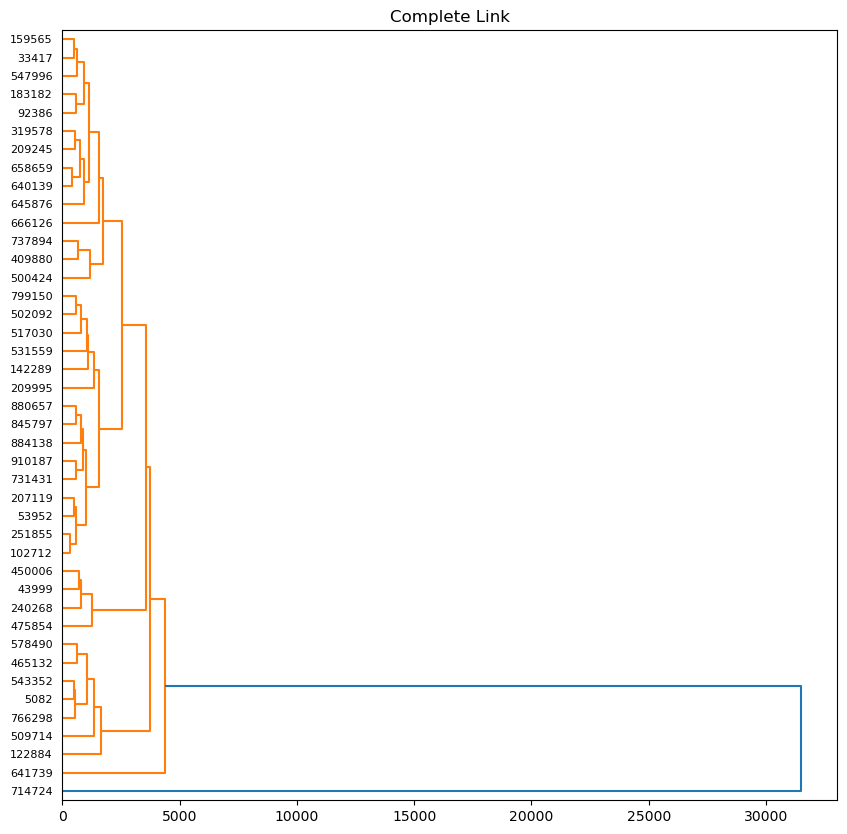

[0 2 2 0 2 0 0 0 2 2 0 2 0 2 0 2 2 2 0 2 2 0 0 0 0 0 2 0 2 0 2 2 2 1 0 2 0
 0 0 0 0 0]


In [64]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
#mat = np.array([[0,4,25,24,9,7], [4,0,21,20,5,3], [25,21,0,1,16,18], [24,20,1,0,15,17], [9,5,16,15,0,2], [7,3,18,17,2,0] ])
#dists = squareform(matrix)
linkage_matrix = linkage(matrixOne, "complete")
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean')
model.fit(matrixOne)
fig, ax = plt.subplots(figsize=(10, 10)) 
dendrogram(linkage_matrix, labels=[  5082,  33417,  43999,  53952,  92386, 102712, 122884, 142289, 159565, 183182, 207119, 209245, 209995, 
                   240268, 251855, 319578, 409880, 450006, 465132, 475854, 500424, 502092, 509714, 517030, 531559, 543352,
                   547996, 578490, 640139, 641739, 645876, 658659, 666126, 714724, 731431, 737894, 766298, 799150, 845797,
                   880657, 884138, 910187], orientation="right")
plt.title("Complete Link")
plt.show()
print(model.labels_)

/home/oluleye/miniconda3/envs/176b/lib/python3.11/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


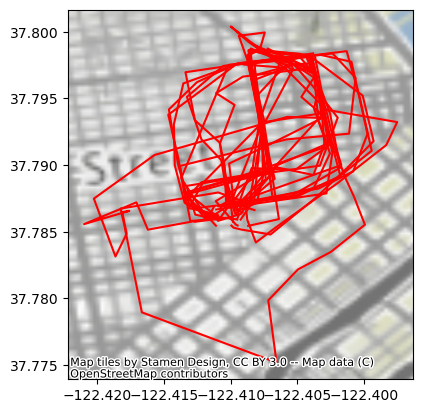

In [65]:
#base = analysis1.plot(color='white', alpha = 0.1, edgecolor='black')

ax2 = line_intersect1.plot(ax, color='red');

ctx.add_basemap(ax2, crs = analysis2.crs.to_string(), zoom = 12)

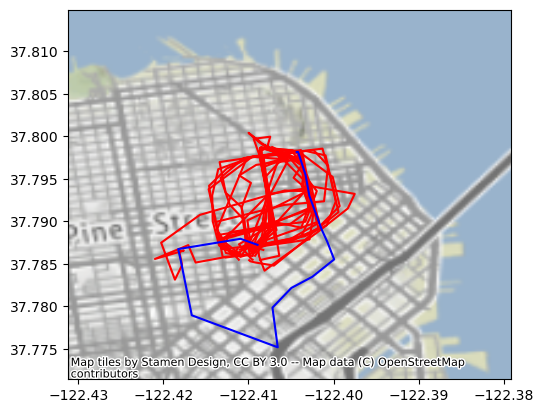

In [66]:
#line = line_intersect2[line_intersect2['trip']].isin[839469, 907466]
valList1 = [5082,  33417,  43999,  53952,  92386, 102712, 122884, 142289, 159565, 183182, 207119, 209245, 209995, 
                   240268, 251855, 319578, 409880, 450006, 465132, 475854, 500424, 502092, 509714, 517030, 531559, 543352,
                   547996, 578490, 640139, 641739, 645876, 658659, 666126, 731431, 737894, 766298, 799150, 845797,
                   880657, 884138, 910187]

valList2 = [714724]


group1 = line_intersect1["trip"].isin(valList1)

group2 = line_intersect1["trip"].isin(valList2)

group1 = line_intersect1[group1]
group2 = line_intersect1[group2]

base = analysis.plot(color='None', alpha = 0.1, edgecolor='None')

ax2 = group1.plot(ax = base, color='red');
ax3 = group2.plot(ax = ax2, color='blue');

ctx.add_basemap(ax3, crs = analysis2.crs.to_string(), zoom = 12)

In [ ]:
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

lineNos = list(points2['trip'].unique())
tripone_Similarity = pd.DataFrame(columns = ['A', 'B', 'Distance'])

for index, value in enumerate(lineNos):
    dframe = points2[points2['trip'] == value].reset_index()
    dFrame = points2.copy()
    dFrame.drop(dFrame[dFrame.trip == value].index, inplace=True)
    lines = lineNos.copy()
    lines.remove(value)
    for ix, val in enumerate(lines):
        distList = []
        dist = 0
        newFrame = dFrame[dFrame['trip'] == val].reset_index()
        for idx, row in dframe.iterrows():
            distanceList = []
            for ind, Val in newFrame.iterrows():
                points_df = gpd.GeoDataFrame({'geometry': [dframe.geometry.iloc[idx], 
                                                           newFrame.geometry.iloc[ind]]},
                                             crs='EPSG:4326').to_crs('EPSG:3857')
                points_df2 = points_df.shift(1)
                #points_df2.geometry.crs = points_df.crs
                distance = points_df.distance(points_df2)
                distance = distance.loc[1]
                distanceList.append(distance)
                dist += distance
            distList.append(min(distanceList))
        tripone_Similarity.loc[len(tripone_Similarity)] = [value, val, max(distList)]
        del newFrame

tripone_Similarity["A"] = tripone_Similarity["A"].astype(int)
tripone_Similarity["B"] = tripone_Similarity["B"].astype(int)

for index, val in tripone_Similarity.iterrows():
    distList = []
    valA = (tripone_Similarity.A.iloc[index])
    valB = (tripone_Similarity.B.iloc[index])
    distA = (tripone_Similarity.Distance.iloc[index])
    distList.append(distA)
    tripframe = tripone_Similarity[(tripone_Similarity['A'] == valB) & (tripone_Similarity['B'] == valA)].copy()
    distB = tripframe.Distance.iloc[0]
    distList.append(distB)
    distance = max(distList)
    tripone_Similarity.Distance.iloc[index] = distance
    tripone_Similarity.loc[((tripone_Similarity['A'] == valB) & (tripone_Similarity['B'] == valA)), 'Distance'] = distance

In [ ]:
tripone_Similarity.to_csv('tripTwoMatrix.csv')

In [67]:
np.set_printoptions(suppress=True, precision=6)
tripMatrix = pd.read_csv('tripTwoMatrix.csv')
tripMatrix.drop('Unnamed: 0', axis=1, inplace=True)
tripMatrix['A'] = tripMatrix['A'].astype('int')
tripMatrix['B'] = tripMatrix['B'].astype('int')
tripMatrix['Dist'] = 1 - (tripMatrix['Distance'] / tripMatrix['Distance'].max()) 
tripMatrix.head(60)

,A,B,Distance,Dist
0,6773,151125,822.09539,0.65643
1,6773,198441,1312.16676,0.45161
2,6773,282354,1808.72384,0.24409
3,6773,326349,1539.67359,0.35653
4,6773,394249,1545.49938,0.35410
5,6773,453866,1804.68036,0.24578
6,6773,485100,1417.77506,0.40748
7,6773,564042,1467.98060,0.38649
8,6773,620523,1306.12169,0.45414
9,6773,657479,1440.16416,0.39812


In [68]:
matrixTwo = pd.DataFrame(0, index=np.arange(23), columns = [6773, 151125, 198441, 282354, 326349, 394249, 453866, 485100, 564042, 620523,
                                657479, 715029, 717276, 722114, 738295, 747857, 772649, 821899, 839469, 869156,
                                881294, 904330, 907466])
matrixTwo.index = [6773, 151125, 198441, 282354, 326349, 394249, 453866, 485100, 564042, 620523,
                                657479, 715029, 717276, 722114, 738295, 747857, 772649, 821899, 839469, 869156,
                                881294, 904330, 907466]

In [69]:
tripTwoValList = [6773, 151125, 198441, 282354, 326349, 394249, 453866, 485100, 564042, 620523,
            657479, 715029, 717276, 722114, 738295, 747857, 772649, 821899, 839469, 869156,
            881294, 904330, 907466]

for idx, row in matrixTwo.iterrows():
    for index in tripTwoValList:
        if(index != idx):
            newFrame = (tripMatrix[(tripMatrix['A'] == idx) & (tripMatrix['B'] == index)]).reset_index()
            matrixTwo.loc[idx, index] = newFrame.Distance.iloc[0]
            del newFrame

In [71]:
matrixTwo

,6773,151125,198441,282354,326349,394249,453866,485100,564042,620523,...,722114,738295,747857,772649,821899,839469,869156,881294,904330,907466
6773,0.00000,822.09539,1312.16676,1808.72384,1539.67359,1545.49938,1804.68036,1417.77506,1467.98060,1306.12169,...,1341.95674,1435.33629,1466.18416,229.56206,2222.82740,1694.08156,1449.83904,846.85067,1151.69027,1225.86400
151125,822.09539,0.00000,1475.06797,1583.98286,1525.98809,1536.29017,1650.01023,1504.60022,1622.28460,1516.15371,...,1500.00806,1652.82221,1556.99990,649.03072,2375.71997,1341.65396,1589.52550,363.78173,1001.20366,1144.57196
198441,1312.16676,1475.06797,0.00000,1110.66890,828.77158,848.02261,1151.60679,1073.00916,993.30281,597.72395,...,1096.37820,839.64353,957.54612,1291.51981,2264.13086,1719.59411,1048.89082,1525.48564,1602.25740,1837.72293
282354,1808.72384,1583.98286,1110.66890,0.00000,915.80521,998.63278,998.37810,1061.54781,1149.39780,959.63517,...,1071.71245,1265.84324,1040.40431,1686.83883,2274.93683,1636.74731,1005.09911,1594.97049,1591.75467,1519.18172
326349,1539.67359,1525.98809,828.77158,915.80521,0.00000,797.45361,1310.55650,1072.37551,762.21341,892.39791,...,1084.03923,1243.68389,453.99281,1553.32163,2283.96058,1516.13384,930.82395,1547.08294,1564.23537,1482.19776
394249,1545.49938,1536.29017,848.02261,998.63278,797.45361,0.00000,1480.30570,529.31914,379.58221,917.18897,...,697.88202,1313.17675,854.46261,1563.54001,2161.88685,1526.45535,339.73695,1557.31757,1495.55965,1488.50298
453866,1804.68036,1650.01023,1151.60679,998.37810,1310.55650,1480.30570,0.00000,1209.26308,1244.47985,1031.36511,...,1127.43706,965.75490,1074.80362,1731.06981,2283.93484,1677.91548,1228.73073,1670.13175,1632.99174,1457.85848
485100,1417.77506,1504.60022,1073.00916,1061.54781,1072.37551,529.31914,1209.26308,0.00000,906.50313,1095.41970,...,369.79749,1099.79594,1085.00898,1366.96734,2118.77984,1765.70424,781.10588,1544.25691,1364.77696,1798.09121
564042,1467.98060,1622.28460,993.30281,1149.39780,762.21341,379.58221,1244.47985,906.50313,0.00000,893.01259,...,956.33164,1022.03144,798.07489,1450.46237,2196.34492,1475.61794,368.94136,1629.45304,1647.45294,1454.70542
620523,1306.12169,1516.15371,597.72395,959.63517,892.39791,917.18897,1031.36511,1095.41970,893.01259,0.00000,...,1107.79820,814.61308,1003.42832,1303.77970,2392.77273,1622.11435,1012.85515,1569.60495,1611.10318,1922.74895


/tmp/ipykernel_64/26385227.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(matrixTwo, "complete")
/home/oluleye/miniconda3/envs/176b/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/oluleye/miniconda3/envs/176b/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


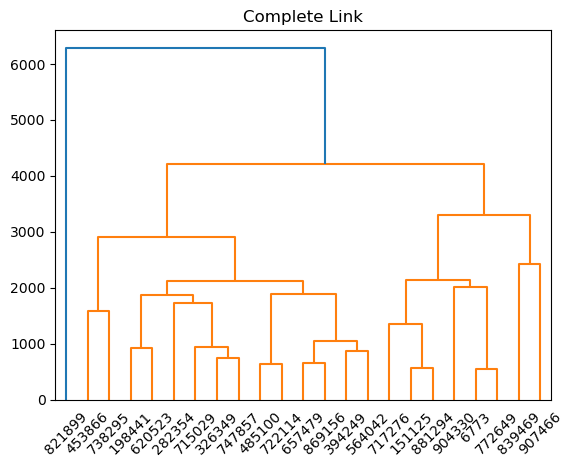

[1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 2 1 0 1 1 1]


In [70]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
#mat = np.array([[0,4,25,24,9,7], [4,0,21,20,5,3], [25,21,0,1,16,18], [24,20,1,0,15,17], [9,5,16,15,0,2], [7,3,18,17,2,0] ])
#dists = squareform(matrix)
linkage_matrix = linkage(matrixTwo, "complete")
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
model.fit(matrixTwo)
dendrogram(linkage_matrix, labels=[6773, 151125, 198441, 282354, 326349, 394249, 453866, 485100, 564042, 620523,
            657479, 715029, 717276, 722114, 738295, 747857, 772649, 821899, 839469, 869156,
            881294, 904330, 907466])
plt.title("Complete Link")
plt.show()
print(model.labels_)

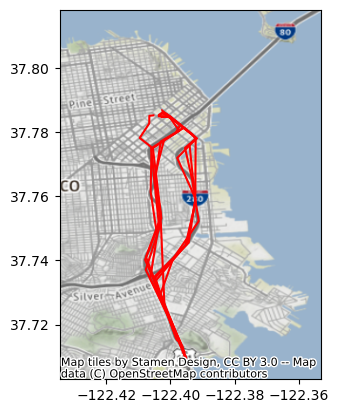

In [72]:
#line = line_intersect2[line_intersect2['trip']].isin[839469, 907466]
valList1 = [6773, 151125, 198441, 282354,  453866, 620523,
            657479, 717276, 722114, 738295, 747857, 772649, 839469,
            881294, 904330, 907466]

valList2 = [839469, 881294, 904330, 747857, 6773, 453866, 620523, 282354, 907466]

valList3 = [821899]

new = line_intersect2["trip"].isin(valList2)

new = line_intersect2[new]

base = analysis2.plot(color='None', alpha = 1, edgecolor='None')

ax = new.plot(ax=base,color='red', edgecolor = 'black');

ctx.add_basemap(ax, crs = analysis2.crs.to_string(), zoom = 12)

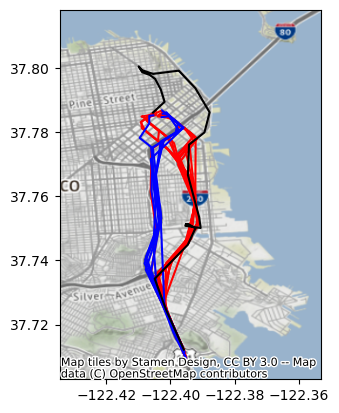

In [73]:
#line = line_intersect2[line_intersect2['trip']].isin[839469, 907466]
valList1 = [198441, 282354, 326349, 394249, 453866, 485100, 564042, 620523,
                                657479, 715029, 722114, 738295, 747857, 869156,
                                881294]

valList2 = [839469, 151125, 717276, 907466, 772649, 6773, 904330, 839469]

valList3 = [821899]

values = [6773, 151125, 198441, 282354, 326349, 394249, 453866, 485100, 564042, 620523,
            657479, 715029, 717276, 722114, 738295, 747857, 772649, 821899, 839469, 869156,
            881294, 904330, 907466]

group1 = line_intersect2["trip"].isin(valList1)

group2 = line_intersect2["trip"].isin(valList2)

group3 = line_intersect2["trip"].isin(valList3)

group1 = line_intersect2[group1]
group2 = line_intersect2[group2]
group3 = line_intersect2[group3]


base = analysis2.plot(color='None', alpha = 0.1, edgecolor='None')
#fig, ax = plt.subplots(figsize=(8, 8)) 
ax2 = group1.plot(ax = base, color='red', figsize=(10, 10));
ax3 = group2.plot(ax = ax2, color='blue');
ax4 = group3.plot(ax = ax3, color='black', legend = True);

ctx.add_basemap(ax4, crs = analysis2.crs.to_string(), zoom = 12)

In [103]:
analysis_3DF = originDestination[(originDestination['origin'] == 60750128021) & (originDestination['destination'] == 60750117003)]

In [104]:
analysis_3trips = list(analysis_3DF['trip'])

analysis3 = gpd.read_file('../analysis_2.geojson')

In [105]:
points3 = dataFrame[dataFrame['trip'].isin(analysis_3trips)]

points3 = gpd.GeoDataFrame(data=points3, crs='epsg:4326', 
                              geometry=gpd.points_from_xy(points3.Longitude, points3.latitude))


In [106]:
intersect3 = gpd.sjoin(points3, analysis3, predicate ='within')
intersect3 = intersect3[['OBJECTID', 'GRID_ID', 'geoid', 'Longitude','latitude', 'geometry', 'trip',  'Time']]

In [107]:
intersect3.sort_values(['trip', 'Time'],ascending = True,  inplace=True)
intersect3.drop_duplicates(subset=['trip', 'geometry'], keep='last')

,OBJECTID,GRID_ID,geoid,Longitude,latitude,geometry,trip,Time
363566,69348,AJX-703,NaN,-122.40780,37.79363,POINT (-122.40780 37.79363),34053,09:22:36
363567,20632,AKA-720,NaN,-122.40715,37.79016,POINT (-122.40715 37.79016),34053,09:23:29
363568,89431,AKC-727,NaN,-122.40690,37.78891,POINT (-122.40690 37.78891),34053,09:23:39
2102363,70067,AHB-688,NaN,-122.42363,37.79658,POINT (-122.42363 37.79658),197004,07:52:14
2102364,90080,AHQ-728,NaN,-122.42050,37.78867,POINT (-122.42050 37.78867),197004,07:53:14
...,...,...,...,...,...,...,...,...
9211230,63021,AHI-727,NaN,-122.42206,37.78888,POINT (-122.42206 37.78888),864625,08:14:11
9211231,20935,AIN-725,NaN,-122.41558,37.78928,POINT (-122.41558 37.78928),864625,08:15:12
9211232,61596,AJV-730,NaN,-122.40837,37.78838,POINT (-122.40837 37.78838),864625,08:17:13
9211233,65796,AJZ-735,NaN,-122.40750,37.78746,POINT (-122.40750 37.78746),864625,08:18:15


In [108]:
line_intersect3 = intersect3.groupby(['trip'])['geometry'].apply(lambda x: LineString(x.tolist()))
line_intersect3 = gpd.GeoDataFrame(line_intersect3, crs='epsg:4326', geometry='geometry')
line_intersect3 = line_intersect3.reset_index()
line_intersect3.head()

,trip,geometry
0,34053,"LINESTRING (-122.40780 37.79363, -122.40715 37..."
1,197004,"LINESTRING (-122.42363 37.79658, -122.42050 37..."
2,277280,"LINESTRING (-122.42397 37.79833, -122.40849 37..."
3,301481,"LINESTRING (-122.42625 37.79306, -122.42492 37..."
4,431108,"LINESTRING (-122.42381 37.79765, -122.42021 37..."


In [ ]:
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

lineNos = list(points3['trip'].unique())
tripSimilarity = pd.DataFrame(columns = ['A', 'B', 'Distance'])

for index, value in enumerate(lineNos):
    dframe = points3[points3['trip'] == value].reset_index()
    dFrame = points3.copy()
    dFrame.drop(dFrame[dFrame.trip == value].index, inplace=True)
    lines = lineNos.copy()
    lines.remove(value)
    for ix, val in enumerate(lines):
        distList = []
        dist = 0
        newFrame = dFrame[dFrame['trip'] == val].reset_index()
        for idx, row in dframe.iterrows():
            distanceList = []
            for ind, Val in newFrame.iterrows():
                points_df = gpd.GeoDataFrame({'geometry': [dframe.geometry.iloc[idx], 
                                                           newFrame.geometry.iloc[ind]]},
                                             crs='EPSG:4326').to_crs('EPSG:3857')
                points_df2 = points_df.shift(1)
                #points_df2.geometry.crs = points_df.crs
                distance = points_df.distance(points_df2)
                distance = distance.loc[1]
                distanceList.append(distance)
                dist += distance
            distList.append(min(distanceList))
        tripSimilarity.loc[len(tripSimilarity)] = [value, val, max(distList)]
        del newFrame

tripSimilarity["A"] = tripSimilarity["A"].astype(int)
tripSimilarity["B"] = tripSimilarity["B"].astype(int)

for index, val in tripSimilarity.iterrows():
    distList = []
    valA = (tripSimilarity.A.iloc[index])
    valB = (tripSimilarity.B.iloc[index])
    distA = (tripSimilarity.Distance.iloc[index])
    distList.append(distA)
    tripframe = tripSimilarity[(tripSimilarity['A'] == valB) & (tripSimilarity['B'] == valA)].copy()
    distB = tripframe.Distance.iloc[0]
    distList.append(distB)
    distance = max(distList)
    tripSimilarity.Distance.iloc[index] = distance
    tripSimilarity.loc[((tripSimilarity['A'] == valB) & (tripSimilarity['B'] == valA)), 'Distance'] = distance

In [ ]:
tripSimilarity.to_csv('tripMatrixb1.csv')

In [109]:
np.set_printoptions(suppress=True, precision=6)
tripMatrix = pd.read_csv('tripMatrixb1.csv')
tripMatrix.drop('Unnamed: 0', axis=1, inplace=True)
tripMatrix['A'] = tripMatrix['A'].astype('int')
tripMatrix['B'] = tripMatrix['B'].astype('int')
tripMatrix['Dist'] = 1 - (tripMatrix['Distance'] / tripMatrix['Distance'].max()) 
tripMatrix.head(60)

,A,B,Distance,Dist
0,34053,197004,1500.86323,0.33004
1,34053,277280,1109.52209,0.50473
2,34053,301481,2031.97097,0.09296
3,34053,431108,1248.78865,0.44256
4,34053,449396,1839.83063,0.17873
5,34053,451465,1248.31559,0.44277
6,34053,550447,2032.05442,0.09292
7,34053,550951,1213.06410,0.45851
8,34053,571770,1183.01792,0.47192
9,34053,576494,1677.79699,0.25106


In [110]:
matrix = pd.DataFrame(0, index=np.arange(18), columns = [ 34053, 197004, 277280, 301481, 431108, 449396, 451465, 550447,
                                                            550951, 571770, 576494, 604408, 664789, 709855, 712680, 825580,
                                                            835211, 864625])

matrix.index = [ 34053, 197004, 277280, 301481, 431108, 449396, 451465, 550447,
                  550951, 571770, 576494, 604408, 664789, 709855, 712680, 825580,
                   835211, 864625]

In [111]:
triponeList = [ 34053, 197004, 277280, 301481, 431108, 449396, 451465, 550447,
                  550951, 571770, 576494, 604408, 664789, 709855, 712680, 825580,
                  835211, 864625]

for idx, row in matrix.iterrows():
    for index in triponeList:
        if(index != idx):
            newFrame = (tripMatrix[(tripMatrix['A'] == idx) & (tripMatrix['B'] == index)]).reset_index()
            matrix.loc[idx, index] = newFrame.Distance.iloc[0]
            del newFrame

In [112]:
matrix

,34053,197004,277280,301481,431108,449396,451465,550447,550951,571770,576494,604408,664789,709855,712680,825580,835211,864625
34053,0.00000,1500.86323,1109.52209,2031.97097,1248.78865,1839.83063,1248.31559,2032.05442,1213.06410,1183.01792,1677.79699,1266.07156,1911.49006,1265.50056,1230.23703,2072.74971,754.94950,1669.53833
197004,1500.86323,0.00000,1414.57340,575.28656,1037.29475,1169.15114,1051.88070,603.85062,1035.53842,1122.72945,586.42576,1063.08389,556.39665,1033.01416,1059.61512,1535.15661,1349.54849,363.12124
277280,1109.52209,1414.57340,0.00000,1675.69011,529.32194,1371.17588,827.90192,1682.68334,707.89051,735.63494,1418.19180,588.97517,1160.27518,594.72591,702.41321,1823.78605,955.67957,1348.10271
301481,2031.97097,575.28656,1675.69011,0.00000,1426.79242,983.25478,1305.45050,510.00738,1307.91991,1582.96703,501.61108,1478.41113,787.62599,1333.80570,1311.42947,1314.67623,1912.85196,484.03766
431108,1248.78865,1037.29475,529.32194,1426.79242,0.00000,1170.38606,434.43883,1407.34584,363.88195,357.48229,1127.99375,370.50308,955.67117,288.31823,468.80634,1489.69707,1228.13543,1272.96501
449396,1839.83063,1169.15114,1371.17588,983.25478,1170.38606,0.00000,804.93773,864.91637,993.56450,1440.14187,1165.28576,1351.96869,750.55011,1151.34644,951.95827,1146.93638,1982.98014,993.13762
451465,1248.31559,1051.88070,827.90192,1305.45050,434.43883,804.93773,0.00000,1313.86084,570.31647,689.49884,1051.06429,570.71291,774.50543,543.01971,566.24890,1372.49184,1252.51348,978.27646
550447,2032.05442,603.85062,1682.68334,510.00738,1407.34584,864.91637,1313.86084,0.00000,1303.47153,1540.21100,558.39922,1450.95869,778.52229,1328.45203,1321.32219,1439.33438,1785.34325,439.18760
550951,1213.06410,1035.53842,707.89051,1307.91991,363.88195,993.56450,570.31647,1303.47153,0.00000,641.34432,1049.88787,443.03912,780.23141,446.35524,434.00641,1441.19333,1228.54492,983.36865
571770,1183.01792,1122.72945,735.63494,1582.96703,357.48229,1440.14187,689.49884,1540.21100,641.34432,0.00000,1169.05444,406.65233,1142.83075,565.18017,649.12889,1746.08056,995.01879,1282.52067


/tmp/ipykernel_64/3020298262.py:6: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(matrix, "complete")


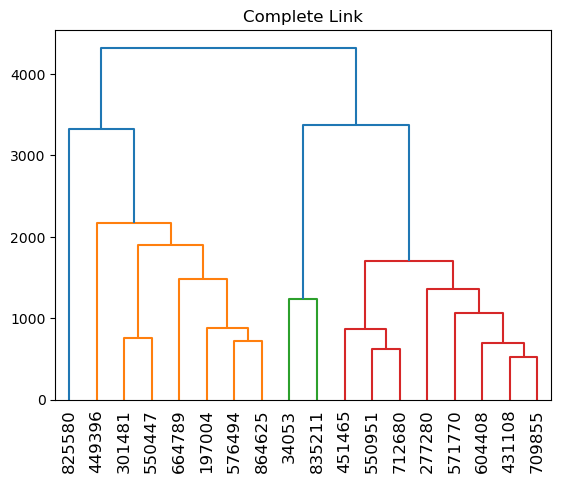

In [113]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
linkage_matrix = linkage(matrix, "complete")
#model = AgglomerativeClustering(n_clusters=3, affinity='euclidean')
#model.fit(matrix)
dendrogram(linkage_matrix, 
           labels=[ 34053, 197004, 277280, 301481, 431108, 449396, 451465, 550447,
                           550951, 571770, 576494, 604408, 664789, 709855, 712680, 825580,
                           835211, 864625],
          leaf_rotation=90)
plt.title("Complete Link")
plt.show()
#print(model.labels_)

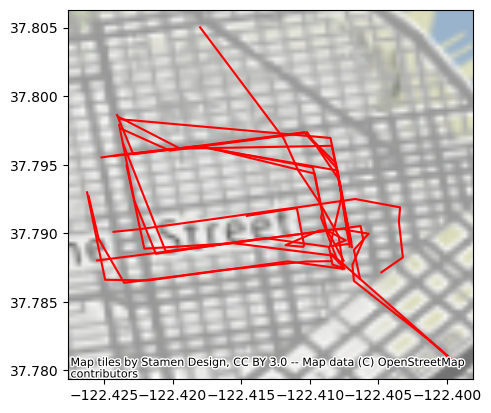

In [117]:
#line = line_intersect2[line_intersect2['trip']].isin[839469, 907466]
valList1 = [825580]
valList2 = [449396, 301481, 550447, 664789, 197004, 576494, 864625]

valList3 = [34053, 835211] 
valList4 = [451465, 550951, 712680, 277280, 571770, 604408, 431108, 709855]

group1 = line_intersect3["trip"].isin(valList1)
group2 = line_intersect3["trip"].isin(valList2)
group3 = line_intersect3["trip"].isin(valList3)
group4 = line_intersect3["trip"].isin(valList4)

group1 = line_intersect3[group1]
group2 = line_intersect3[group2]
group3 = line_intersect3[group3]
group4 = line_intersect3[group4]

#base = analysis3.plot(color='None', alpha = 0.1, edgecolor='None')

ax2 = group1.plot( color='red');
ax3 = group2.plot(ax = ax2, color='red');
ax4 = group3.plot(ax = ax3, color='red');
ax5 = group4.plot(ax = ax4, color='red');

ctx.add_basemap(ax5, crs = analysis3.crs.to_string(), zoom = 12)

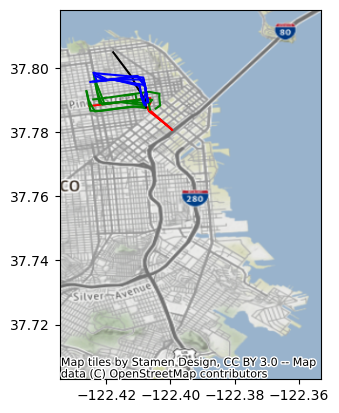

In [116]:
#line = line_intersect2[line_intersect2['trip']].isin[839469, 907466]
valList1 = [825580]
valList2 = [449396, 301481, 550447, 664789, 197004, 576494, 864625]

valList3 = [34053, 835211] 
valList4 = [451465, 550951, 712680, 277280, 571770, 604408, 431108, 709855]

group1 = line_intersect3["trip"].isin(valList1)

group2 = line_intersect3["trip"].isin(valList2)
group3 = line_intersect3["trip"].isin(valList3)
group4 = line_intersect3["trip"].isin(valList4)

group1 = line_intersect3[group1]
group2 = line_intersect3[group2]
group3 = line_intersect3[group3]
group4 = line_intersect3[group4]

base = analysis2.plot(color='None', alpha = 0.1, edgecolor='None')

ax2 = group1.plot(ax = base, color='red');
ax3 = group2.plot(ax = ax2, color='green');
ax4 = group3.plot(ax = ax3, color='black');
ax5 = group4.plot(ax = ax4, color='blue');

ctx.add_basemap(ax5, crs = analysis2.crs.to_string(), zoom = 12)